In [340]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy import optimize
import numpy as np

dépendances : pandas, scipy, matplotlib, numpy

# Importation et formatage des donnés

Importation des donnés à partir le fichier "CO2.csv" téléchargé le 18/07/2024 depuis [https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html]

In [341]:
CO2 = pd.read_csv("CO2.csv", comment = '"', sep = ",", dtype = {"CO2" : float})
CO2.columns = ["Yr", "Mn", "Date-excel", "Date", "CO2", "seasonally", "fit", "seasonally-fit", "CO2-filled", "seasonally-filled", "Sta"]
# Supression des espaces dans le nom des colones
CO2.head()

Yr   Mn Date-excel         Date       CO2  seasonally          fit  \
0                                                 adjusted                
1                 Excel                  [ppm]      [ppm]         [ppm]   
2  1958   01      21200    1958.0411    -99.99      -99.99       -99.99   
3  1958   02      21231    1958.1260    -99.99      -99.99       -99.99   
4  1958   03      21259    1958.2027    315.71      314.44       316.20   

  seasonally-fit    CO2-filled seasonally-filled   Sta  
0   adjusted fit        filled   adjusted filled   NaN  
1          [ppm]         [ppm]             [ppm]   NaN  
2         -99.99        -99.99            -99.99   MLO  
3         -99.99        -99.99            -99.99   MLO  
4         314.91        315.71            314.44   MLO

On passe ensuite la date en indexe. Il faut d'abord suprimer les lignes 0 et 1 qui ne correspondent a aucune date. On garde uniquement la date et la colone "CO2" car c'est la seul variable que l'on va analyser.

In [342]:
CO2 = CO2[["Date", "Yr", "Mn", "CO2"]].drop([0, 1])

On formate la date et on la passe en index

In [343]:
for i in CO2.index :
    CO2.loc[i, "Date"] = f"{CO2.loc[i, "Yr"]}-{CO2.loc[i, "Mn"]}" # Regroupement dans annés "Yr" et des mois "Mn" dans la colone "Date" (suffisant car 1 donné par mois)
CO2.Date = pd.to_datetime(CO2.Date, format = "%Y- %m") # Formatage de la date
CO2.index = CO2.Date # passage de la date en index
CO2.head()

Date    Yr   Mn       CO2
Date                                      
1958-01-01 1958-01-01  1958   01    -99.99
1958-02-01 1958-02-01  1958   02    -99.99
1958-03-01 1958-03-01  1958   03    315.71
1958-04-01 1958-04-01  1958   04    317.45
1958-05-01 1958-05-01  1958   05    317.51

On converti les chiffres en 'str' en donnés numériques 'float'

In [344]:
for i in CO2.index:
    CO2.loc[i, "CO2"] = float(CO2.loc[i, "CO2"])
    CO2.loc[i, "Yr"] = float(CO2.loc[i, "Yr"])
    CO2.loc[i, "Mn"] = float(CO2.loc[i, "Mn"])
CO2.head()

Date      Yr   Mn     CO2
Date                                      
1958-01-01 1958-01-01  1958.0  1.0  -99.99
1958-02-01 1958-02-01  1958.0  2.0  -99.99
1958-03-01 1958-03-01  1958.0  3.0  315.71
1958-04-01 1958-04-01  1958.0  4.0  317.45
1958-05-01 1958-05-01  1958.0  5.0  317.51

Pour les régression, on rajoute une colone numérique pour la date au format Yr+Mn/12 soit un nombre décimal d'anné

In [345]:
CO2.insert(4, "numDate", CO2.Yr+CO2.Mn/12)
CO2.head()

Date      Yr   Mn     CO2      numDate
Date                                                   
1958-01-01 1958-01-01  1958.0  1.0  -99.99  1958.083333
1958-02-01 1958-02-01  1958.0  2.0  -99.99  1958.166667
1958-03-01 1958-03-01  1958.0  3.0  315.71      1958.25
1958-04-01 1958-04-01  1958.0  4.0  317.45  1958.333333
1958-05-01 1958-05-01  1958.0  5.0  317.51  1958.416667

# Visualisation

<Axes: xlabel='Date', ylabel='CO2 concentration (ppm)'>

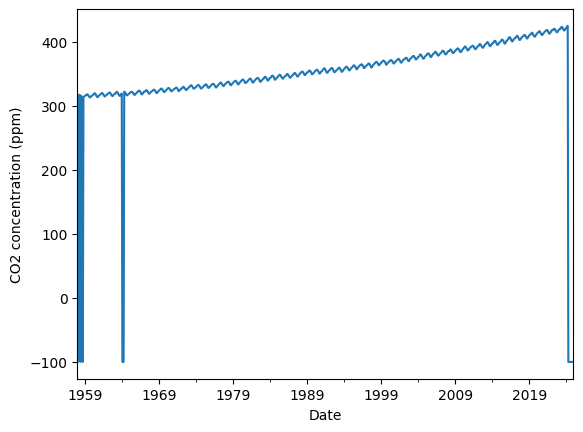

In [346]:
CO2.CO2.plot(ylabel = "CO2 concentration (ppm)")

On trouve des valeurs abhérantes (concentration négatives) entre 1958 et 1959, entre 1963 et 1964 et après 2024 qu'on visualise en zoomant sur ces périodes :

<Axes: xlabel='Date'>

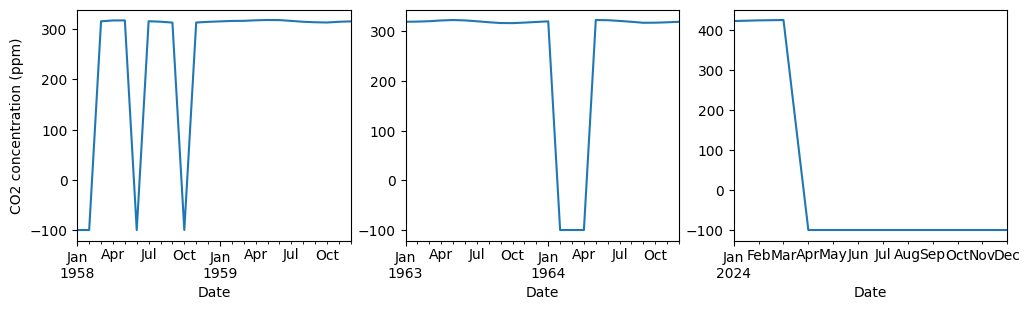

In [347]:
plt.figure(figsize = (12, 3))
plt.subplot(1, 3, 1)
CO2["1958":"1959"]["CO2"].plot(ylabel = "CO2 concentration (ppm)")
plt.subplot(1, 3, 2)
CO2["1963":"1964"]["CO2"].plot()
plt.subplot(1, 3, 3)
CO2["2024":]["CO2"].plot()

Ces valeurs abhérantes sont enregistrés sur une durée de 1 mois (sauf après 2024), correspondant à l'enregistrement de la moyenne mensuelle. Elle sont probablement due à un problème dans l'acquisition des donnés car la même valeur (-99.99ppm) revient de façon ponctuelle. On les supprime donc dans le [Pré traitement](#-Pré-traitement)

# Pré-traitement

On supprime toute les concentration négatives (physiquement impossibles)

<Axes: xlabel='Date', ylabel='CO2 concentration (ppm)'>

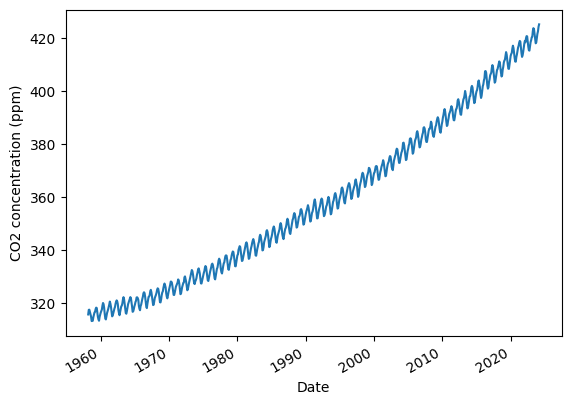

In [348]:
CO2 = CO2[CO2.CO2 >= 0]
CO2.CO2.plot(ylabel = "CO2 concentration (ppm)")

# Traitement

On detrend le signal pour séparer les tendances à long terme (de 1960 à 2024) et à court terme (anuelle)

## Detrending linéaire

In [349]:
CO2.insert(4, "lin-detrended-CO2", detrend(CO2.CO2, type = "linear"))

<Axes: xlabel='Date'>

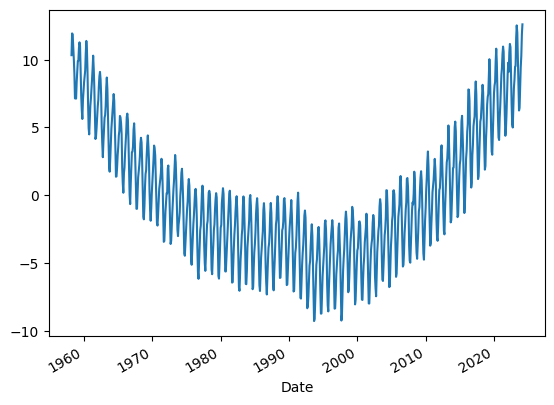

In [350]:
CO2["lin-detrended-CO2"].plot()

## Régression exponentiel

Au vue de la courbure obtenue ci dessus, on remarque qu'un modèle linéaire n'est pas suffisant. Aussi la concentration semble d'avantage suivre une loi exponentiel, on développe donc un modèle exponentiel de type $ c(t)=K*e^{\alpha t}+c_{0} $ où c(t) est sa concentration à la date t et K, $c_{0}$ et $ \alpha $ des paramètres à déterminer par régression.

In [445]:
def c(t, k, alpha, c0):# definition du modèle
    return k*np.exp(alpha*t)+c0
#c(t, 1, 0.0001, 0)
params, cov = optimize.curve_fit(c, t, CO2.CO2, bounds=([0, 0.001, 0], [5, 0.1, 20]), method = "trf") # Optimisation des paramètres

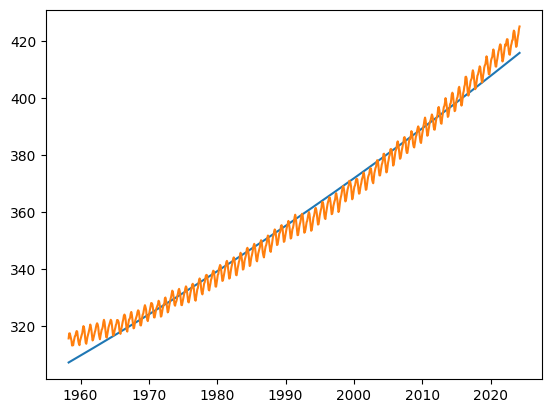

In [446]:
plt.plot(t, c(t, params[0], params[1], params[2]))
plt.plot(t, CO2.CO2)

Finalement, le modèle exponentiel ne permet pas de suivre la tendance de la courbe, ce qui peut être vérifier en traçant ci dessous le graph sur une échelle log car il ne forme pas une droite.

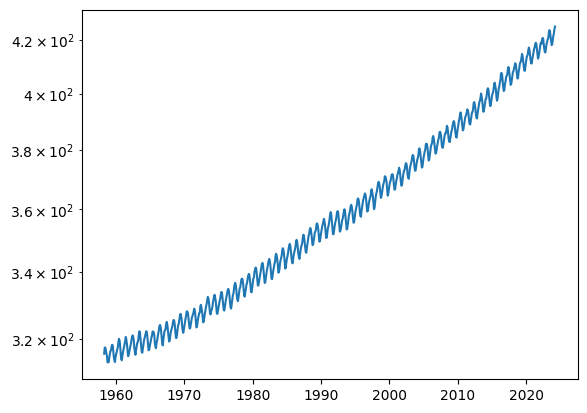

In [447]:
plt.figure()
plt.yscale("log")
plt.plot(t, CO2.CO2)

## Modèle polynomial du 2nd degré

### caractérisation de la tendance à long terme

On fait donc l'hypothèse d'une tendance polynomiale du 2nd degré dont on développe le modèle ci dessous

Text(0.5, 0, 'Année')

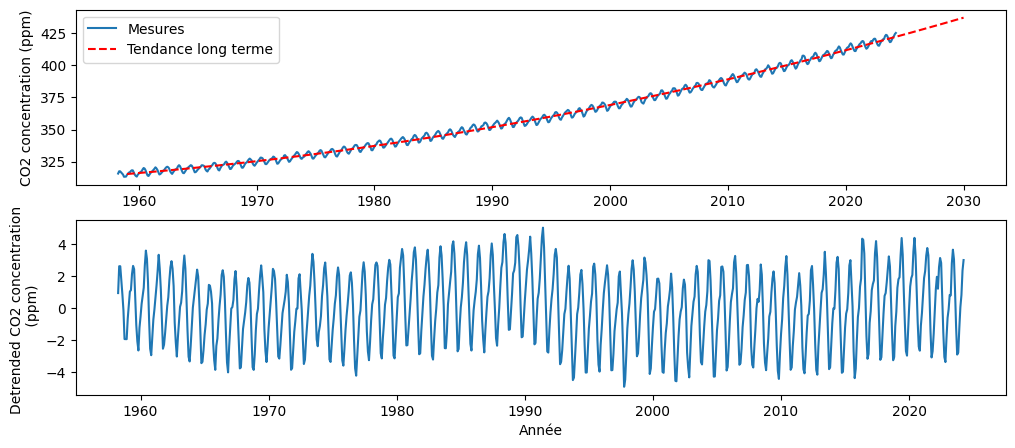

In [485]:
def p(t, a, b, d): # definition du modèle
    return a*t**2+b*t+d

params, cov = optimize.curve_fit(p, t, CO2.CO2) # Optimisation des paramètres
c_out = p(t, params[0], params[1], params[2])
# Plot
plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1) # graph tendance long terme
plt.plot(t, CO2.CO2, label = "Mesures") # trace les donnés
t2 = np.linspace(1959, 2030, 1000) # prolongement de la courbe jusqu'en 2030
plt.plot(t2, p(t2, params[0], params[1], params[2]), c = "r", label = "Tendance long terme", ls = "--") # trace le modèle
plt.ylabel("CO2 concentration (ppm)")
plt.legend()
plt.subplot(2, 1, 2) # graph tendance court terme
plt.plot(t, CO2.CO2-c_out)
plt.ylabel("Detrended CO2 concentration \n (ppm)")
plt.xlabel("Année")

In [443]:
params

array([ 1.36006066e-02, -5.25333910e+01,  5.10334886e+04])

On obtiens un modèle représentant bien la tendance et définit par : $c(t)=at²+bt+d$ avec a = 1.36006066e-02 ppm/an², b = -52.5333910 ppm/an et c = 5.10334886e+04 ppm

### Caractérisation de l'oscilation anuelle

Pour lire les caractéristique des variation, on zomm sur le graphique ci dessus (ici entre 2016 et 2024 mais un autre intervalle conviendrais aussi)  

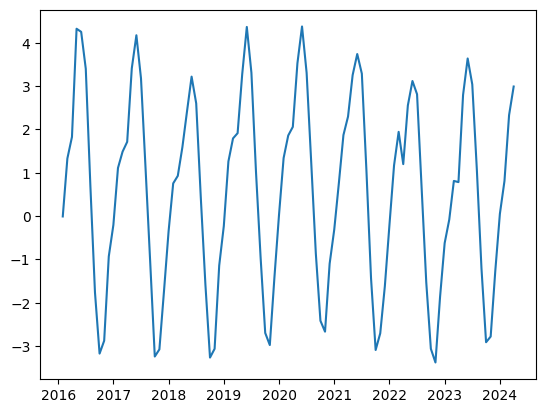

In [487]:
tsample = t[t>2016]
tsample
plt.plot(tsample, CO2.CO2[CO2.numDate>2016]-p(tsample, params[0], params[1], params[2]))

Par lecture graphique, l'oscilation est caractérisé par une période de 1 an et une amplitude variant entre 6 et 7ppm